# A Spam Classifier
> This project builds a spam classifier using Apache SpamAssassin's public datasets.

- toc:true
- branch: master
- badges: true
- comments: true
- author: Peiyi Hong
- categories: [project, machine learning, classification]
- image: images/roc.png

# Introduction

In this project, I built a spam classifer by implementing machine learning models. Models were trained by the datasets from [Apache SpamAssassin website](https://spamassassin.apache.org/old/publiccorpus/).

# Get the data

## Download emails and load them into my program

In [1]:
#collapse-hide
import os
import urllib
import tarfile
import urllib.request

download_root = "https://spamassassin.apache.org/old/publiccorpus/"
file_names = ["20030228_easy_ham.tar.bz2", "20030228_easy_ham_2.tar.bz2",
              "20030228_hard_ham.tar.bz2", "20030228_spam.tar.bz2",
              "20030228_spam_2.tar.bz2"]
store_path = os.path.join("data")

def fetch_data(root_url=download_root, file_names=file_names,
               store_path=store_path):
    
    # make directory storing emails
    os.makedirs(store_path, exist_ok=True)
    
    # download files 
    for file in file_names:
        file_url = os.path.join(download_root, file)
        path = os.path.join(store_path, file)
        urllib.request.urlretrieve(file_url, path)
    
    # extract emails
    for file in file_names:
        path = os.path.join(store_path, file)
        with tarfile.open(path, 'r') as f:
            f.extractall(path=store_path)

#fetch_data()

# get file names of emails
email_folders = ["hard_ham", "easy_ham", "easy_ham_2", 
                 "spam", "spam_2"]
ham_names = {}
for ham in email_folders[:3]:
    ham_path = os.path.join(store_path, ham)
    names = [name for name in sorted(os.listdir(ham_path)) if len(name) > 20]
    ham_names[ham] = names
    
spam_names = {}
for spam in email_folders[3:]:
    spam_path = os.path.join(store_path, spam)
    names = [name for name in sorted(os.listdir(spam_path)) if len(name) > 20]
    spam_names[spam] = names

# parse emails
import email
import email.policy

def load_email(directory, filename, spam_path=store_path):
    path = os.path.join(spam_path, directory)
    with open(os.path.join(path, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
hams = []
for ham in email_folders[:3]:
    emails = [load_email(ham, filename=name) for name in ham_names[ham]]
    hams.extend(emails)
spams = []
for spam in email_folders[3:]:
    emails = [load_email(spam, filename=name) for name in spam_names[spam]]
    spams.extend(emails)

explain how to download the emails and load them in my notebook

In [2]:
len(hams), len(spams), len(spams) / (len(hams) + len(spams))

(4150, 1897, 0.31370927732760046)

Accuracy of random guess is 70%, so we must do better than that.

## Take a look at the emails

**headers**

In [3]:
hams[1].items()

[('Return-Path', '<malcolm-sweeps@mrichi.com>'),
 ('Delivered-To', 'rod@arsecandle.org'),
 ('Received', '(qmail 16821 invoked by uid 505); 7 May 2002 14:37:01 -0000'),
 ('Received',
  'from malcolm-sweeps@mrichi.com by blazing.arsecandle.org\t by uid 500 with qmail-scanner-1.10 (F-PROT: 3.12. Clear:0. Processed in 0.260914 secs); 07 May 2002 14:37:01 -0000'),
 ('Delivered-To', 'rod-3ds@arsecandle.org'),
 ('Received', '(qmail 16811 invoked by uid 505); 7 May 2002 14:37:00 -0000'),
 ('Received',
  'from malcolm-sweeps@mrichi.com by blazing.arsecandle.org\t by uid 502 with qmail-scanner-1.10 (F-PROT: 3.12. Clear:0. Processed in 0.250416 secs); 07 May 2002 14:37:00 -0000'),
 ('Received',
  'from bocelli.siteprotect.com (64.41.120.21)  by h0090272a42db.ne.client2.attbi.com with SMTP; 7 May 2002 14:36:59 -0000'),
 ('Received',
  'from mail.mrichi.com ([208.33.95.187])\tby bocelli.siteprotect.com (8.9.3/8.9.3) with SMTP id JAA14328;\tTue, 7 May 2002 09:37:01 -0500'),
 ('From', 'malcolm-sweeps

In [4]:
hams[1]["Subject"]

'Malcolm in the Middle Sweepstakes Prize Notification'

**Contents**

In [5]:
print(hams[1].get_content()[:600])

May 7, 2002


Dear rod-3ds@arsecandle.org:


Congratulations!  On behalf of Frito-Lay, Inc., we are pleased to advise you
 that you've won Fourth Prize in the 3D's(R) Malcolm in the Middle(TM)
 Sweepstakes.   Fourth Prize consists of 1 manufacturer's coupon redeemable at
 participating retailers for 1 free bag of 3D's(R) brand snacks (up to 7 oz.
 size), with an approximate retail value of $2.59 and an expiration date of
 12/31/02.

Follow these instructions to claim your prize:

1.	Print out this email message.

2.	Complete ALL of the information requested.  Print clearly and legibly.  Sign
 


## Get email structure

There are some emails that have multiple parts.

In [6]:
from collections import Counter 

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structure_counter(emails):
    structures = [get_email_structure(email) for email in emails]
    return Counter(structures)

In [7]:
structure_counter(hams).most_common()

[('text/plain', 3832),
 ('text/html', 120),
 ('multipart(text/plain, application/pgp-signature)', 101),
 ('multipart(text/plain, text/html)', 63),
 ('multipart(text/plain, text/plain)', 5),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/x-pkcs7-signature)', 2),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  2),
 ('multipart(text/plain, image/bmp)', 1),
 ('multipart(multipart(text/plain, text/html))', 1),
 ('multipart(text/plain, image/png, image/png)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/jpeg, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif)',
  1),
 ('multipart(text/pla

In [8]:
structure_counter(spams).most_common()

[('text/plain', 816),
 ('text/html', 772),
 ('multipart(text/plain, text/html)', 159),
 ('multipart(text/html)', 49),
 ('multipart(text/plain)', 44),
 ('multipart(multipart(text/html))', 23),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream)', 3),
 ('multipart(text/html, text/plain)', 3),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart/alternative', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, 

It seems that most hams are plain text, while spams are more often html. What we need to do next?

# Preprocessing emails

write helper funtions and make pipeline

## Split emails into train and test set

In [9]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

X = np.array(hams+spams)
y = np.array([0] * len(hams) + [1] * len(spams))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=44, 
                                                    stratify=y)
X_train.shape, X_test.shape

((4837,), (1210,))

## Email to text

**Parse HTML**

In [10]:
from bs4 import BeautifulSoup

def html_to_plain_text(html):
    soup = BeautifulSoup(html, "lxml")
    strings = ""
    for i in soup.find_all():
        if i.string:
            strings += i.string + "\n"
    return strings

**Turn email to plain text**

In [11]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [12]:
example_spam = email_to_text(spams[10])
print(example_spam)

Cellular Phone Accessories All At Below Wholesale Prices!

http://202.101.163.34:81/sites/merchant/sales/

Hands Free Ear Buds 1.99! 
Phone Holsters 1.98! 
Booster Antennas Only $0.99
Phone Cases 1.98! 
Car Chargers 1.98! 
Face Plates As Low As 0.99! 
Lithium Ion Batteries As Low As 6.94! 

http://202.101.163.34:81/sites/merchant/sales/

Click Below For Accessories On All NOKIA, MOTOROLA LG, NEXTEL, 
SAMSUNG, QUALCOMM, ERICSSON, AUDIOVOX PHONES At Below 
WHOLESALE PRICES!

http://202.101.163.34:81/sites/merchant/sales/

***If You Need Assistance Please Call Us (732) 751-1457***


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
To be removed from future mailings please send your remove 
request to: removemenow68994@btamail.net.cn 
Thank You and have a super day :)




## Replace url with "URL"

In [13]:
import re
url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
example_spam = re.sub(url_pattern, "URL", example_spam)
example_spam

'Cellular Phone Accessories All At Below Wholesale Prices!\n\nURL\n\nHands Free Ear Buds 1.99! \nPhone Holsters 1.98! \nBooster Antennas Only $0.99\nPhone Cases 1.98! \nCar Chargers 1.98! \nFace Plates As Low As 0.99! \nLithium Ion Batteries As Low As 6.94! \n\nURL\n\nClick Below For Accessories On All NOKIA, MOTOROLA LG, NEXTEL, \nSAMSUNG, QUALCOMM, ERICSSON, AUDIOVOX PHONES At Below \nWHOLESALE PRICES!\n\nURL\n\n***If You Need Assistance Please Call Us (732) 751-1457***\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nTo be removed from future mailings please send your remove \nrequest to: removemenow68994@btamail.net.cn \nThank You and have a super day :)\n\n'

## Tokenize

In [15]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

example_spam_tokenized = word_tokenize(example_spam)
example_spam_tokenized[:10]

[nltk_data] Downloading package punkt to /Users/hongpeiyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Cellular',
 'Phone',
 'Accessories',
 'All',
 'At',
 'Below',
 'Wholesale',
 'Prices',
 '!',
 'URL']

## Stemming

In [19]:
def stemming_email(tokenized_email):
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokenized_email]
    return " ".join(stemmed_words)

stemmed_eamil = stemming_email(example_spam_tokenized)
stemmed_eamil

'cellular phone accessori all At below wholesal price ! url hand free ear bud 1.99 ! phone holster 1.98 ! booster antenna onli $ 0.99 phone case 1.98 ! car charger 1.98 ! face plate As low As 0.99 ! lithium ion batteri As low As 6.94 ! url click below for accessori On all nokia , motorola LG , nextel , samsung , qualcomm , ericsson , audiovox phone At below wholesal price ! url ***if you need assist pleas call Us ( 732 ) 751-1457*** ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ To be remov from futur mail pleas send your remov request to : removemenow68994 @ btamail.net.cn thank you and have a super day : )'

## Write a sklearn estimator to transform our email

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToTokenizedStemmed(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
                text = re.sub(url_pattern, "URL", text)
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'[^a-zA-Z0-9]+', ' ', text, flags=re.M)
            text = word_tokenize(text)
            text = stemming_email(text)
            X_transformed.append(text)
        return np.array(X_transformed)

## Vectorizing

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Make Pipeline

In [22]:
from sklearn.pipeline import Pipeline

email_pipeline = Pipeline([
    ("Tokenizing and Stemming", EmailToTokenizedStemmed()),
    ("tf-idf Vectorizing", TfidfVectorizer()),
    ("passthrough", None)
])

## The processed datasets

In [23]:
X_train_processed = email_pipeline.fit_transform(X_train)
X_test_processed = email_pipeline.transform(X_test)

___

# Modeling

In [25]:
# machine learning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# others
from scipy.stats import uniform, randint, loguniform
import joblib # storing models

**Functions from evaluating and comparing models**

In [34]:
models = {} # storing trained models
models_names = [] # storing models names

# add models and its name to dict
def add_model(name, model, 
              models_list=models,
              name_list=models_names):
    name_list.append(name)
    models_list[name] = model

In [27]:
def get_classification_report(model, X_test=X_test_processed, y_test=y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, 
                                target_names=["not spam", "spam"],
                                digits=4))

## Building models and tuning them

how I trained and tuned the models? what's the process?

### Naive Bayes (baseline model)

In [36]:
nb = MultinomialNB().fit(X_train_processed, y_train)

In [38]:
add_model("Naive Bayes", nb)

### Logistic regression

In [26]:
logitCV = LogisticRegressionCV(max_iter=1000,
                               Cs=20, cv=10,
                               scoring="accuracy")
logitCV.fit(X_train_processed, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001, verbose=0)

In [45]:
add_model("Logistic regression", logitCV)

### SVM

In [ ]:
svc = SVC()
svc_params = {'C': loguniform(1e0, 1e3),
              'gamma': loguniform(1e-4, 1e-3),
              'kernel': ['rbf'],
              'class_weight':['balanced', None]}
svc_grid = RandomizedSearchCV(svc, svc_params, 
                              n_jobs=-1, cv=10,
                              n_iter=15, scoring="accuracy")

svc_grid.fit(X_train_processed, y_train)

svc_best = svc_grid.best_estimator_

#svc = joblib.load("tmp/svc.pkl")

In [42]:
svc.get_params()

{'C': 280.3887191550727,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.000984422644629166,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
add_model("SVM", svc)

### Random Forest

In [47]:
max_depths = [10, 50, 100, 150]
for depth in max_depths:
    rf = RandomForestClassifier(n_jobs=-1, oob_score=True, 
                                n_estimators=1500, random_state=44,
                                max_depth=depth)
    rf.fit(X_train_processed, y_train)
    print(f"Max Depth: {depth:3}, oob accuracy: {rf.oob_score_:.4f}")

Max Depth:  10, oob accuracy: 0.8594
Max Depth:  50, oob accuracy: 0.9692
Max Depth: 100, oob accuracy: 0.9711
Max Depth: 150, oob accuracy: 0.9694


In [49]:
max_depths = [90, 100, 110, 120, 130]
for depth in max_depths:
    rf = RandomForestClassifier(n_jobs=-1, oob_score=True, 
                                n_estimators=1000, random_state=44,
                                max_depth=depth)
    rf.fit(X_train_processed, y_train)
    print(f"Max Depth: {depth:3}, oob accuracy: {rf.oob_score_:.4f}")

Max Depth:  90, oob accuracy: 0.9700
Max Depth: 100, oob accuracy: 0.9711
Max Depth: 110, oob accuracy: 0.9704
Max Depth: 120, oob accuracy: 0.9708
Max Depth: 130, oob accuracy: 0.9698


In [50]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, 
                            n_estimators=1000, random_state=44,
                            max_depth=100)
rf.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=44, verbose=0,
                       warm_start=False)

In [51]:
add_model("Random forest", rf)

## Evaluate on test set

In [118]:
for name in models_names:
    print(name)
    get_classification_report(models[name])
    print("-----------------------------------------")
    print()

Naive Bayes
              precision    recall  f1-score   support

    not spam     0.8494    0.9988    0.9181       830
        spam     0.9957    0.6132    0.7590       380

    accuracy                         0.8777      1210
   macro avg     0.9226    0.8060    0.8385      1210
weighted avg     0.8953    0.8777    0.8681      1210

-----------------------------------------

Logistic regression
              precision    recall  f1-score   support

    not spam     0.9927    0.9880    0.9903       830
        spam     0.9740    0.9842    0.9791       380

    accuracy                         0.9868      1210
   macro avg     0.9833    0.9861    0.9847      1210
weighted avg     0.9868    0.9868    0.9868      1210

-----------------------------------------

SVM
              precision    recall  f1-score   support

    not spam     0.9891    0.9880    0.9885       830
        spam     0.9738    0.9763    0.9750       380

    accuracy                         0.9843      1210
   mac

## Comparing performance of models using ROC curve and AUC

In [115]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(models_names=models_names, models=models):
    
    plt.figure(dpi=120)
    for name in models_names:
        if name == "SVM":
            y_score = models[name].decision_function(X_test_processed)
            fpr, tpr, thresholds = roc_curve(y_test, y_score)
            auc = roc_auc_score(y_test, y_score)
            label = name + f"({auc:.4f})"
            plt.plot(fpr, tpr, label=label)
        else:
            y_score = models[name].predict_proba(X_test_processed)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_score)
            auc = roc_auc_score(y_test, y_score)
            label = name + f"({auc:.4f})"
            plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0,1], "b--")
    plt.xlim(-0.01, 1.02)
    plt.ylim(-0.01, 1.02)
    plt.legend(title="Model (AUC score)",loc=(1.01, 0.4))

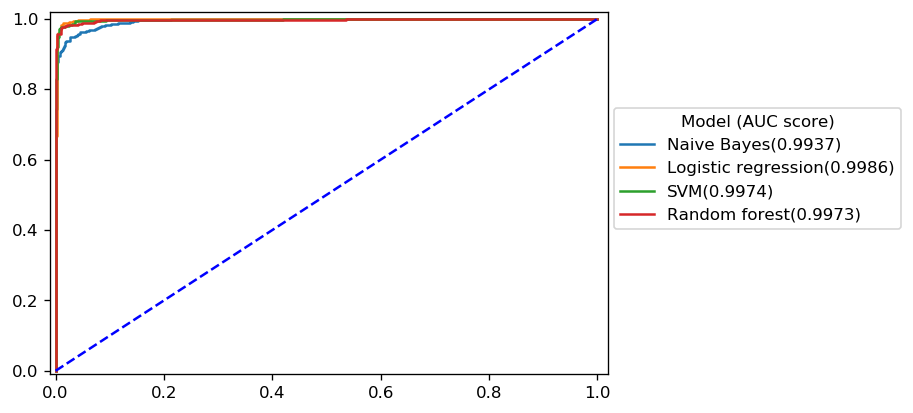

In [116]:
plot_roc_curve()

# Conclusion